# Crypto Currencies - Time Series Forecasting
# <font color='blue'>0. Identification for Business Requirements</font> <a class="anchor" id="first-bullet"></a>

### A Short Description About the Dataset & It's Source


####  Dataset of Bitcoin Historical Data

## <font color= blue >1. Importing the Necessary Libraries</font> <a class="anchor" id="second-bullet"></a>

In [1]:
#!pip install cryptocmd
#!pip install arch

In [2]:
# Standard library imports
import os
import time
import warnings
import sys
import requests
import os 
import pickle

# Third party imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.metrics import r2_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from cryptocmd import CmcScraper
from datetime import datetime, timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Models
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM, Dropout, Dense, Input, Attention
from keras.models import Model
from keras.layers import ConvLSTM2D, Dropout, Flatten, Dense
from keras.models import Sequential
from prettytable import PrettyTable




# Local application imports
# Import other necessary libraries and modules here
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, Span, Range1d
from bokeh.layouts import column
from bokeh.models.widgets import Button
from bokeh.models.callbacks import CustomJS
from bokeh.themes import Theme
from math import pi
import pandas as pd
from bokeh.plotting import figure, show
from bokeh.models import HoverTool
from bokeh.models import ColumnDataSource, WheelZoomTool
import pandas as pd
import tensorflow as tf

warnings.filterwarnings('ignore')


# Block 1 - CryptoData

In [3]:
# Block 1 - load data with CmC Scrapper
class CryptoData:
    """
    This class is responsible for fetching and formatting cryptocurrency data.

    Input:
        crypto_symbol (str): The symbol of the cryptocurrency, e.g., "BTC" for Bitcoin.

    Methods:
        get_cryptocmd_data: Fetches cryptocurrency data and returns a formatted DataFrame.
        get_display_data: Fetches and formats cryptocurrency data for display purposes.
    """
    def __init__(self, crypto_symbol: str):
        self.crypto_symbol = crypto_symbol

    def _fetch_cryptocmd_data(self) -> pd.DataFrame:
        try:
            scraper = CmcScraper(self.crypto_symbol)
            df = scraper.get_dataframe()
            if not {'Date', 'Open', 'High', 'Low', 'Close', 'Market Cap', 'Volume'}.issubset(df.columns):
                raise ValueError("Some expected columns are missing in the data.")
            return df
        except Exception as e:
            print(f'An error occurred while fetching data: {e}')
            raise  # Propagate the exception

    def get_cryptocmd_data(self) -> pd.DataFrame:
        df = self._fetch_cryptocmd_data()
        df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
        return df.round(2)

    @staticmethod
    def _format_monetary_value(value: float) -> str:
        return "${:,.2f}".format(value)

    @staticmethod
    def _format_volume_value(value: float) -> str:
        if value > 1e9:
            return "{:.2f}B".format(value/1e9)
        elif value > 1e6:
            return "{:.2f}M".format(value/1e6)
        else:
            return "{:,.2f}".format(value)

    def get_display_data(self) -> pd.DataFrame:
        display_df = self.get_cryptocmd_data().copy()
        monetary_columns = ['Open', 'High', 'Low', 'Close']
        display_df[monetary_columns] = display_df[monetary_columns].applymap(self._format_monetary_value)

        # Check and apply volume formatting only if they are of numeric type
        volume_like_columns = ['Volume', 'Market Cap']
        for column in volume_like_columns:
            if pd.api.types.is_numeric_dtype(display_df[column]):
                display_df[column] = display_df[column].apply(self._format_volume_value)

        return display_df

In [4]:
crypto = CryptoData("BTC")
data = crypto.get_cryptocmd_data()
display_data = crypto.get_display_data()
display_data

,Open,High,Low,Close,Volume,Market Cap
Date,,,,,,
2023-06-29,"$30,086.19","$30,796.25","$30,057.20","$30,445.35",13.18B,591.11B
2023-06-28,"$30,696.56","$30,703.28","$29,921.82","$30,086.25",14.57B,584.11B
2023-06-27,"$30,274.32","$31,006.79","$30,236.65","$30,688.16",16.43B,595.77B
2023-06-26,"$30,480.52","$30,636.03","$29,955.74","$30,271.13",16.49B,587.65B
2023-06-25,"$30,545.15","$31,041.27","$30,327.94","$30,480.26",12.70B,591.68B
...,...,...,...,...,...,...
2013-05-02,$116.38,$125.60,$92.28,$105.21,0.00,1.17B
2013-05-01,$139.00,$139.89,$107.72,$116.99,0.00,1.30B
2013-04-30,$144.00,$146.93,$134.05,$139.00,0.00,1.54B


# Block 2 - Crypto Analytics

In [5]:
class CryptoAnalytics:
    """
    This class is responsible for performing analytics on cryptocurrency data.

    Input:
        df (pd.DataFrame): The DataFrame containing the cryptocurrency data.

    Methods:
        get_all_time_records: Returns the all-time high and low closing prices.
        get_yearly_analysis: Returns yearly high, low, average, and variation.
        get_monthly_analysis: Returns monthly high, low, average, and variation.
        get_weekly_analysis: Returns weekly high, low, average, and variation.
    """
    def __init__(self, crypto_data: pd.DataFrame):
        self.df = crypto_data
        if not isinstance(self.df, pd.DataFrame):
            raise ValueError(f"Expected a pandas DataFrame, but got {type(crypto_data)}")
        if not {'Open', 'Close'}.issubset(self.df.columns):
            raise ValueError("Input DataFrame should contain 'Open' and 'Close' columns")

    def format_and_round(self, number: float) -> str:
        return '{:.2f}'.format(number)

    def _apply_formatting(self, df:pd.DataFrame) -> pd.DataFrame:
        ordered_columns = ['Open_first', 'Close_last', 'variation_$_abs',
            'variation_%_rel', 'Close_min', 'Close_mean', 'Close_max']        
        return df[ordered_columns]

    def _calculate_variation(self, df: pd.DataFrame) -> pd.DataFrame:
        df['variation_$_abs'] = df['Close_last'] - df['Open_first']
        df['variation_%_rel'] = ((df['Close_last'] - df['Open_first']) / df['Open_first']) * 100
        return df
    
    def _get_generic_analysis(self, df: pd.DataFrame, freq: str) -> pd.DataFrame:
        analysis_df = df.resample(freq).agg({'Close': ['last', 'mean', 'max', 'min'], 'Open': 'first'})
        analysis_df.columns = analysis_df.columns.map('_'.join).str.strip('_')
        analysis_df = self._calculate_variation(analysis_df)
        return self._apply_formatting(analysis_df)
    
    def get_all_time_records(self):
        all_time_high = self.df['Close'].max()
        all_time_low = self.df['Close'].min()
        all_time_high_date = self.df['Close'].idxmax().strftime('%Y-%m-%d')
        all_time_low_date = self.df['Close'].idxmin().strftime('%Y-%m-%d')
        return all_time_high, all_time_low, all_time_high_date, all_time_low_date
    
    def get_yearly_analysis(self):
        return self._get_generic_analysis(self.df, 'Y')

    def get_monthly_analysis(self):
        return self._get_generic_analysis(self.df, 'M')

    def get_weekly_analysis(self):
        return self._get_generic_analysis(self.df, 'W')

    def display_all_analyses(self):
        from prettytable import PrettyTable
        all_time_high, all_time_low, all_time_high_date, all_time_low_date = self.get_all_time_records()

        x = PrettyTable()
        
        x.field_names = ["Analysis", "Value"]
        x.add_row(["All Time High", f"{self.format_and_round(all_time_high)} (Date: {all_time_high_date})"])
        x.add_row(["All Time Low", f"{self.format_and_round(all_time_low)} (Date: {all_time_low_date})"])
        
        print(x)

        print("\nYearly Analysis:")
        display(self.get_yearly_analysis())

        print("\nMonthly Analysis:")
        display(self.get_monthly_analysis())

        print("\nWeekly Analysis:")
        display(self.get_weekly_analysis())
        

In [6]:
crypto_analytics = CryptoAnalytics(data)
# Now we can call functions on this object:
crypto_analytics.display_all_analyses()

+---------------+-----------------------------+
|    Analysis   |            Value            |
+---------------+-----------------------------+
| All Time High | 67566.83 (Date: 2021-11-08) |
|  All Time Low |   68.43 (Date: 2013-07-05)  |
+---------------+-----------------------------+

Yearly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-12-31,135.30,754.01,618.71,457.287509,68.43,257.474395,1151.17
2014-12-31,754.97,320.19,-434.78,-57.589043,310.74,527.236548,953.29
2015-12-31,320.43,430.57,110.14,34.372562,178.10,272.453397,465.32
2016-12-31,430.72,963.74,533.02,123.750929,364.33,568.492186,975.92
2017-12-31,963.66,14156.40,13192.74,1369.024345,777.76,4006.033616,19497.40
2018-12-31,14112.20,3742.70,-10369.50,-73.478976,3236.76,7572.298877,17527.00
2019-12-31,3746.71,7193.60,3446.89,91.997779,3399.47,7395.246630,13016.23
2020-12-31,7194.89,29001.72,21806.83,303.087747,4970.79,11116.377869,29001.72
2021-12-31,28994.01,46306.45,17312.44,59.710402,29374.15,47436.932247,67566.83



Monthly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-30,135.30,139.00,3.70,2.734664,134.21,139.250000,144.54
2013-05-31,139.00,129.00,-10.00,-7.194245,97.75,119.992581,133.48
2013-06-30,128.82,96.61,-32.21,-25.003881,94.65,107.761333,129.30
2013-07-31,97.51,106.09,8.58,8.799098,68.43,90.512258,107.99
2013-08-31,106.21,135.35,29.14,27.436211,102.80,113.905161,135.35
...,...,...,...,...,...,...,...
2023-02-28,23137.84,23147.35,9.51,0.041102,21651.18,23304.538214,24829.15
2023-03-31,23150.93,28478.48,5327.55,23.012250,20187.24,25116.900645,28478.48
2023-04-30,28473.33,29268.81,795.48,2.793772,27276.91,28851.102667,30485.70



Weekly Analysis:


,Open_first,Close_last,variation_$_abs,variation_%_rel,Close_min,Close_mean,Close_max
Date,,,,,,,
2013-04-28,135.30,134.21,-1.09,-0.805617,134.21,134.210000,134.21
2013-05-05,134.44,115.91,-18.53,-13.783100,97.75,118.842857,144.54
2013-05-12,115.98,115.00,-0.98,-0.844973,111.50,113.925714,117.20
2013-05-19,114.82,121.99,7.17,6.244557,111.50,118.708571,123.50
2013-05-26,122.50,133.48,10.98,8.963265,122.00,127.732857,133.48
...,...,...,...,...,...,...,...
2023-06-04,28075.59,27119.07,-956.52,-3.406945,26819.97,27275.950000,27745.88
2023-06-11,27123.11,25940.17,-1182.94,-4.361373,25760.10,26303.555714,27238.78
2023-06-18,25934.29,26336.21,401.92,1.549763,25124.68,25956.664286,26510.68


# Block 3 - Crypto Visual

In [7]:
# block 3
class CryptoVisual:
    """
    This class is responsible for creating candlestick charts with a moving average line using Bokeh.

    Input:
        data (pd.DataFrame): DataFrame containing OHLC data with 'Date' as the index.

    Methods:
        create_candlestick_chart: Creates a candlestick chart with a moving average line using Bokeh.
        create_line_chart: Creates a line chart with a moving average line using Bokeh.
    """
    def __init__(self, data: pd.DataFrame):
        self.data = data

    def create_candlestick_chart(self, time_period: str='last_month', ma_period: int=20):
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        inc = df.Close > df.Open
        dec = df.Open > df.Close

        # Create separate ColumnDataSources for positive and negative daily variations
        source_inc = ColumnDataSource(df[inc])
        source_dec = ColumnDataSource(df[dec])
        source_hover = ColumnDataSource(df)

        w = 12 * 60 * 60 * 1000  # half day in ms

        TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

        p = figure(x_axis_type="datetime", tools=TOOLS, width=950, title="Crypto Candlestick with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot positive daily variations (green)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_inc)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#39B86B", line_color="black", source=source_inc)

        # Plot negative daily variations (red)
        p.segment('index_col', 'High', 'index_col', 'Low', color="black", source=source_dec)
        p.vbar('index_col', w, 'Open', 'Close', fill_color="#F2583E", line_color="black", source=source_dec)

        # Enable scroll wheel zoom
        p.toolbar.active_scroll = p.select_one(WheelZoomTool)

        # Add hover tool
        hover = HoverTool(
            tooltips=[
                ("Date", "@index_col{%F}"),  # date hover label
                ("Open", "@{Open}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Close", "@{Close}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("High", "@{High}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("Low", "@{Low}{($ 0,0.00)}"),  # two decimal places, comma as thousand separator, and dollar sign
                ("MA", "@{MA}{($ 0,0.00)}"),  # moving average hover label
            ],
            formatters={
                '@index_col': 'datetime',  # format date hover label as date
                '@Open': 'numeral',  # format numerical data
                '@Close': 'numeral',  # format numerical data
                '@High': 'numeral',  # format numerical data
                '@Low': 'numeral',  # format numerical data
                '@MA': 'numeral',
            },
            mode='vline'  # display a tooltip whenever the cursor is vertically in line with a glyph
        )
        p.add_tools(hover)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source_hover)

        show(p)  # open a browser

    def create_line_chart(self, time_period: str='last_month', ma_period: int=20):
        df = self._select_data(time_period)

        df['index_col'] = df.index  # add a new column with the index values
        df['MA'] = df['Close'].rolling(window=ma_period).mean()  # calculate moving average

        source = ColumnDataSource(df)

        p = figure(x_axis_type="datetime", tools="pan,wheel_zoom,box_zoom,reset,save", width=950, title="Crypto Line Chart with MA")
        p.xaxis.major_label_orientation = pi / 4
        p.grid.grid_line_alpha = 0.3

        # Plot line chart
        p.line('index_col', 'Close', color='black', legend_label='Close', source=source)

        # Add moving average line
        p.line('index_col', 'MA', color='blue', legend_label='Moving Average', source=source)

        show(p)  # open a browser

    def _select_data(self, time_period: str) -> pd.DataFrame:
        VALID_PERIODS = ['all_time', 'last_month', 'last_3_months', 'last_6_months', 'last_1_year', 'last_3_years']

        if time_period not in VALID_PERIODS:
            raise ValueError("Invalid value for time_period.")

        time_offsets = {
            "all_time": pd.DateOffset(years=100), # use a large number of years to encompass all data
            "last_month": pd.DateOffset(months=1),
            "last_3_months": pd.DateOffset(months=3),
            "last_6_months": pd.DateOffset(months=6),
            "last_1_year": pd.DateOffset(years=1),
            "last_3_years": pd.DateOffset(years=3)
        }

        period_max = self.data.index.max() - time_offsets[time_period]

        return self.data[self.data.index >= period_max]

In [8]:
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create candlestick chart
crypto_visual.create_candlestick_chart(time_period='last_6_months', ma_period=20)

In [9]:
# Assuming you have the OHLC data in the DataFrame called 'data' with 'Date' as the index
crypto_visual = CryptoVisual(data)
# Create line chart
crypto_visual.create_line_chart(time_period='all_time', ma_period=20)

# Block 4 - TimeSeriesAnalysis

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
import matplotlib.pyplot as plt

class TimeSeriesAnalysis:
    """
    This class provides methods for performing time series analysis on cryptocurrency data.

    Input:
        data (pd.Series or array-like): Time series data to be analyzed.

    Methods:
        check_stationarity: Checks the stationarity of the time series using the Augmented Dickey-Fuller test.
        check_autocorrelation: Plots the autocorrelation and partial autocorrelation functions of the time series.
        check_volatility: Fits a GARCH(1,1) model to the time series and prints the model summary.
    """
    def __init__(self, data, target_column):
        if data is None or len(data) == 0:
            raise ValueError("Data cannot be None or empty")
        elif target_column not in data.columns:
            raise ValueError(f"Target column '{target_column}' not found in data.")
        else:
            self.data = pd.Series(data[target_column])

    def check_stationarity(self):
        result = adfuller(self.data)
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t%s: %.3f' % (key, value))
        
        # Check if ADF Statistic is less than critical values
        if result[0] < min(result[4].values()):
            print("The series is likely stationary.")
        else:
            print("The series is likely non-stationary.")

    def check_autocorrelation(self, title=""):
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))

        plot_acf(self.data, lags=50, alpha=0.05, ax=ax1)
        ax1.set_title(f"ACF for {title}", size=20)

        plot_pacf(self.data, lags=50, alpha=0.05, method='ols', ax=ax2)
        ax2.set_title(f"PACF for {title}", size=20)

    def check_volatility(self):
        try:
            model = arch_model(self.data, vol='Garch', p=1, q=1)
            model_fit = model.fit()
            print(model_fit.summary())
        except Exception as e:
            print("An exception occurred while fitting the model: " + str(e))


In [11]:
# Create instance of Time Series Analysis
series_analysis = TimeSeriesAnalysis(data, 'Close')

In [12]:
series_analysis.check_stationarity()

ADF Statistic: -1.699568
p-value: 0.431335
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
The series is likely non-stationary.


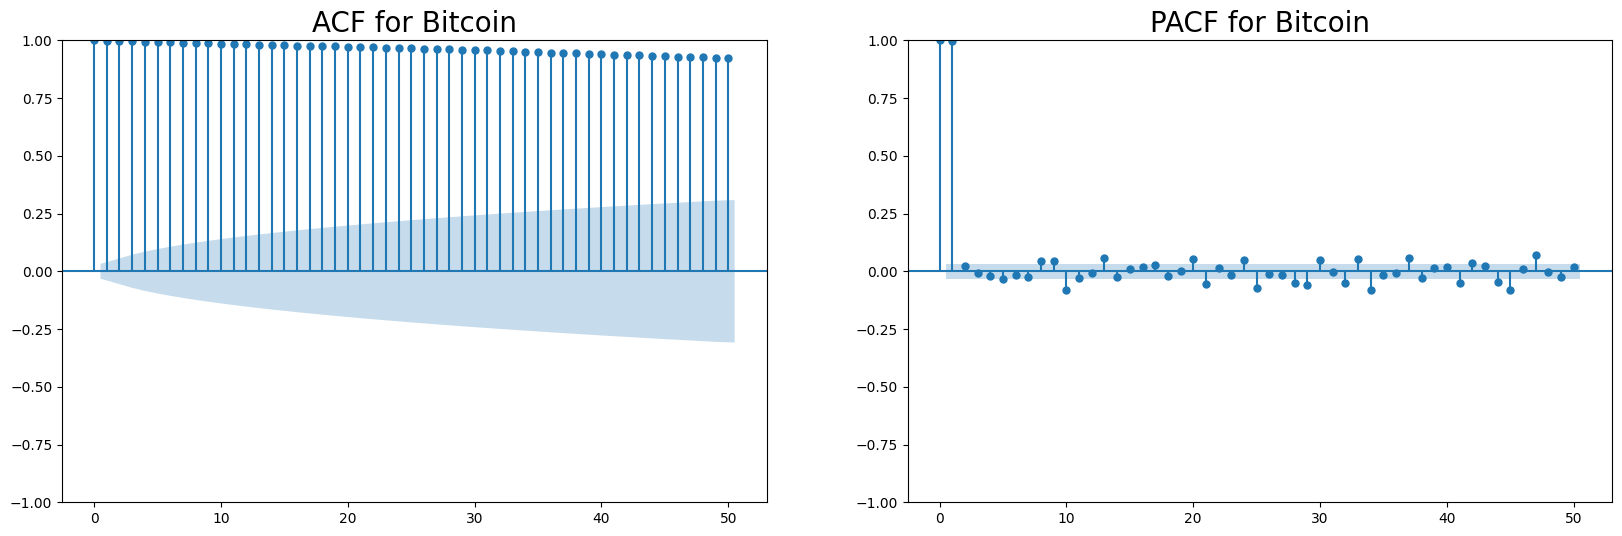

In [13]:
series_analysis.check_autocorrelation(title="Bitcoin")

In [14]:
series_analysis.check_volatility()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 124877.19753189894
Iteration:      2,   Func. Count:     12,   Neg. LLF: 39075.63247449987
Iteration:      3,   Func. Count:     17,   Neg. LLF: 39075.52208667179
Iteration:      4,   Func. Count:     22,   Neg. LLF: 39074.99632336253
Iteration:      5,   Func. Count:     27,   Neg. LLF: 39072.669233296096
Iteration:      6,   Func. Count:     32,   Neg. LLF: 39066.25669878715
Iteration:      7,   Func. Count:     37,   Neg. LLF: 39061.069160168576
Iteration:      8,   Func. Count:     42,   Neg. LLF: 39035.7774795561
Iteration:      9,   Func. Count:     47,   Neg. LLF: 38908.88212829533
Iteration:     10,   Func. Count:     52,   Neg. LLF: 38336.860869308075
Iteration:     11,   Func. Count:     57,   Neg. LLF: 37412.71317376217
Iteration:     12,   Func. Count:     62,   Neg. LLF: 46383.06731520723
Iteration:     13,   Func. Count:     69,   Neg. LLF: 43920.064231289165
Iteration:     14,   Func. Count:     76,   Neg. LLF: 37037.

# Block 5 - Data Pre-Processing

In [15]:
class DataPreprocessing:
    """
    This class provides methods for preprocessing and splitting time series data.

    Input:
        data (pd.DataFrame): The original time series data.
        targets (list): List of target column names.
        columns_to_scale (list): List of column names to be normalized and scaled.
        random_state (int or None): Random state for reproducibility.

    Methods:
        missing_values_table: Creates a table of columns with missing values.
        normalize_and_scale: Normalizes and scales the specified columns in the data.
        split_data: Splits the data into training and testing sets for time series forecasting.
        visualize_split: Visualizes the split between training and testing data using Bokeh.
    """

    def __init__(self, data, target_col, columns_to_scale=None):
        self.data = data.sort_index(ascending=True)
        if target_col not in self.data.columns:
            raise ValueError(f"Column '{target_col}' is not in the input dataframe.")
        if columns_to_scale: 
            missing_cols = [col for col in columns_to_scale if col not in data.columns]
            if missing_cols:
                raise ValueError(f"Columns {missing_cols} are not in the input dataframe.")
        self.target_col = target_col
        self.columns_to_scale = columns_to_scale if columns_to_scale else []
        self.data_scaled = None  # Initialize the data_scaled attribute
    
    def missing_values_table(self):
        mis_val = self.data.isnull().sum()
        mis_val_percent = 100 * mis_val / len(self.data)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
            columns={0: 'Missing Values', 1: '% of Total Values'}
        )
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:, 1] != 0
        ].sort_values('% of Total Values', ascending=False).round(1)

        print(
            f"Your selected dataframe has {self.data.shape[1]} columns.\n"
            f"There are {mis_val_table_ren_columns.shape[0]} columns that have missing values."
        )

        return mis_val_table_ren_columns
    
    def normalize_and_scale(self):
        data_normalized = self.data.copy()
        self.scaler = StandardScaler()
        self.close_scaler = StandardScaler()

        if self.columns_to_scale:
            if self.data[self.columns_to_scale].isnull().values.any():
                raise ValueError("Data contains null values.")
            
            data_normalized[self.columns_to_scale] = self.scaler.fit_transform(data_normalized[self.columns_to_scale])

        self.close_scaler.fit(data_normalized[[self.target_col]])
        self.data_scaled = data_normalized
        return self.data_scaled
    
    
    def split_data(self, splitter, output_shape='2D'):
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")
        if not 0 <= splitter <= 1:
            raise ValueError("'splitter' should be in range [0, 1].")
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")
            
        split_index = int(len(self.data_scaled) * (1 - splitter))
        data_train = self.data_scaled.iloc[:split_index]
        data_test = self.data_scaled.iloc[split_index:]

        X_train = data_train.drop(columns=[self.target_col])
        y_train = data_train[self.target_col]

        X_test = data_test.drop(columns=[self.target_col])
        y_test = data_test[self.target_col]

        self.y_train= y_train.to_numpy()
        self.y_test= y_test.to_numpy()
        X_train= X_train.to_numpy()
        X_test= X_test.to_numpy()

        if output_shape not in ('2D', '3D'):
            raise ValueError("'output_shape' value must be either '2D' or '3D'.")
        if output_shape == '3D':
            X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

        return X_train, self.y_train, X_test, self.y_test
    
    def visualize_split(self, train_close, test_close):
        y_train_restored = self.data[self.target_col][:len(self.y_train)]
        y_test_restored = self.data[self.target_col][len(self.y_train):]
        train_dates = self.data.index[:len(train_close)]
        test_dates = self.data.index[-len(test_close):]

        p = figure(width=950, height=500, x_axis_type="datetime", title="Training and Testing Data")

        p.xgrid.grid_line_color = "gray"
        p.ygrid.grid_line_color = "gray"
        p.xgrid.grid_line_alpha = 0.3
        p.ygrid.grid_line_alpha = 0.3

        # Training Data Line
        p.line(train_dates, y_train_restored, color='blue', legend_label='Training Data', line_width=2)
        p.line(test_dates, y_test_restored, color='orange', legend_label='Testing Data', line_width=2)

        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Value", "$@y{0,0.00}")],
                  formatters={"@x": "datetime"})

        p.add_tools(hover)
        p.toolbar.logo = None
        # Show the dynamic line chart
        show(p)

In [16]:
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
target_col ='Close'
preprocessor = DataPreprocessing(data, target_col=target_col, columns_to_scale=columns_to_scale)
data_normalized = preprocessor.normalize_and_scale()

In [17]:
# Split the data into train and test sets
X_train, y_train, X_test, y_test = preprocessor.split_data(splitter=0.2, output_shape='3D')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2972, 1, 5) (2972,) (743, 1, 5) (743,)


In [18]:
preprocessor.visualize_split(y_train, y_test)

# Block 6 - LSTM Models

In [19]:
class LSTM_Models:
    """
    This class provides methods for training and evaluating LSTM models for time series forecasting.

    Input:
        X_train (ndarray): Training input data.
        y_train (ndarray): Training target data.
        X_test (ndarray): Testing input data.
        y_test (ndarray): Testing target data.
        model (Sequential): LSTM model to be trained and evaluated.

    Methods:
        train_model: Trains the LSTM model on the training data.
        make_predictions: Makes predictions using the trained LSTM model.
        plot_history: Plots the training history of the LSTM model.
        evaluate_model: Evaluates the performance of the LSTM model.
        plot_predictions: Plots the actual and predicted values for the training and testing data.
    """
    def __init__(self, X_train, y_train, X_test, y_test, model):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model

    def train_model(self, epochs=100, batch_size=50):
        tf.compat.v1.reset_default_graph()
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(self.X_test, self.y_test), shuffle=False)

    def make_predictions(self, close_scaler):
        # Make predictions on the normalized data
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)

        # Check the number of LSTM layers in the model
        num_lstm_layers = sum([isinstance(layer, LSTM) for layer in self.model.layers])

        if num_lstm_layers == 1:
            # For models with a single LSTM layer, no reshaping is needed
            train_predict = close_scaler.inverse_transform(train_predict)
            test_predict = close_scaler.inverse_transform(test_predict)
        else:
            # For models with multiple LSTM layers, reshape the predictions
            train_predict = train_predict.reshape(-1, 1)
            test_predict = test_predict.reshape(-1, 1)
            train_predict = close_scaler.inverse_transform(train_predict)
            test_predict = close_scaler.inverse_transform(test_predict)

        y_train_rescaled = close_scaler.inverse_transform([self.y_train])
        y_test_rescaled = close_scaler.inverse_transform([self.y_test])

        # Create DataFrames to compare actual vs predicted values for the training and testing data
        train_comparison_df = pd.DataFrame({
            'Actual': y_train_rescaled[0],
            'Predict': train_predict[:, 0]
        })
        test_comparison_df = pd.DataFrame({
            'Actual': y_test_rescaled[0],
            'Predict': test_predict[:, 0]
        })

        return train_comparison_df, test_comparison_df

    def plot_history(self):
        plt.figure(figsize=(14, 7))
        # Plot the loss
        plt.plot(self.history.history['loss'], label='Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        # Add title and labels
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        # Show the plot
        plt.show()

        from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


    def evaluate_model(self, train_comparison_df, test_comparison_df):
        # Calculate metrics for the training data
        train_rmse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'], squared=False)
        train_mae = mean_absolute_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_mse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_r2 = r2_score(train_comparison_df['Actual'], train_comparison_df['Predict'])
        # Calculate metrics for the testing data
        test_rmse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'], squared=False)
        test_mae = mean_absolute_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_mse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_r2 = r2_score(test_comparison_df['Actual'], test_comparison_df['Predict'])
        # Create a DataFrame to hold the results
        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df

    def plot_predictions(self, train_comparison_df, test_comparison_df):
        plt.figure(figsize=(14, 7))
        # Plot the actual and predicted values for the training data
        plt.subplot(1, 2, 1)
        plt.plot(train_comparison_df['Actual'], label='Actual')
        plt.plot(train_comparison_df['Predict'], label='Predict')
        plt.title('Training Data: Actual vs Predicted')
        plt.legend()
        # Plot the actual and predicted values for the testing data
        plt.subplot(1, 2, 2)
        plt.plot(test_comparison_df['Actual'], label='Actual')
        plt.plot(test_comparison_df['Predict'], label='Predict')
        plt.title('Testing Data: Actual vs Predicted')
        plt.legend()
        # Show the plot
        plt.show()

In [20]:
# Model 1 - Triple Layer
model1 = Sequential()
model1.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
model1.add(Dropout(0.15))
model1.add(LSTM(128,activation="tanh", return_sequences=True))
model1.add(Dropout(0.20))
model1.add(LSTM(256, activation="tanh",return_sequences=True))
model1.add(Dropout(0.25))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()

# Model 8 - Quadruple Layer
model2 = Sequential()
model2.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
model2.add(Dropout(0.15))
model2.add(LSTM(128,activation="tanh", return_sequences=True))
model2.add(Dropout(0.20))
model2.add(LSTM(256, activation="tanh",return_sequences=True))
model2.add(Dropout(0.25))
model2.add(LSTM(256, activation="tanh",return_sequences=True))
model2.add(Dropout(0.30))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()


# Model 6 - Double Layer
model3 = Sequential()
model3.add(LSTM(128,activation="tanh",return_sequences=True, input_shape=(1, 5)))
model3.add(Dropout(0.15))
model3.add(LSTM(128,activation="tanh", return_sequences=True))
model3.add(Dropout(0.2))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
model3.summary()


# Model 4 - Quadruple Layer
input_layer = Input(shape=(1, 5))
lstm_layer = LSTM(256, activation="tanh", return_sequences=True)(input_layer)
dropout_layer = Dropout(0.15)(lstm_layer)
attention_layer = Attention()([dropout_layer, dropout_layer])  # Apply Attention to the same layer
flatten_layer = Flatten()(attention_layer)  # Flatten the output of the Attention layer
output_layer = Dense(1)(flatten_layer)

model4 = Model(inputs=input_layer, outputs=output_layer)
model4.compile(loss='mean_squared_error', optimizer='adam')
model4.summary()


# Model 5 - Single Layer
model5 = Sequential()
model5.add(LSTM(256,activation="tanh",input_shape=(1,5)))
model5.add(Dropout(0.15))
model5.add(Dense(1))
model5.compile(loss='mean_squared_error', optimizer='adam')
model5.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 128)            131584    
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 256)            394240    
                                                                 
 dropout_2 (Dropout)         (None, 1, 256)            0         
                                                                 
 dense (Dense)               (None, 1, 1)              2

Epoch 1/100
60/60 - 5s - loss: 0.1672 - val_loss: 0.4985 - 5s/epoch - 79ms/step
Epoch 2/100
60/60 - 1s - loss: 0.0299 - val_loss: 0.0806 - 654ms/epoch - 11ms/step
Epoch 3/100
60/60 - 1s - loss: 0.0101 - val_loss: 0.0190 - 661ms/epoch - 11ms/step
Epoch 4/100
60/60 - 1s - loss: 0.0049 - val_loss: 0.0129 - 963ms/epoch - 16ms/step
Epoch 5/100
60/60 - 1s - loss: 0.0053 - val_loss: 0.0039 - 752ms/epoch - 13ms/step
Epoch 6/100
60/60 - 1s - loss: 0.0109 - val_loss: 0.0096 - 693ms/epoch - 12ms/step
Epoch 7/100
60/60 - 1s - loss: 0.0187 - val_loss: 0.0022 - 711ms/epoch - 12ms/step
Epoch 8/100
60/60 - 1s - loss: 0.0497 - val_loss: 0.0849 - 790ms/epoch - 13ms/step
Epoch 9/100
60/60 - 1s - loss: 0.0307 - val_loss: 0.0112 - 1s/epoch - 18ms/step
Epoch 10/100
60/60 - 1s - loss: 0.0426 - val_loss: 0.0879 - 903ms/epoch - 15ms/step
Epoch 11/100
60/60 - 1s - loss: 0.0141 - val_loss: 0.0140 - 850ms/epoch - 14ms/step
Epoch 12/100
60/60 - 1s - loss: 0.0120 - val_loss: 0.0191 - 847ms/epoch - 14ms/step
Epoch 1

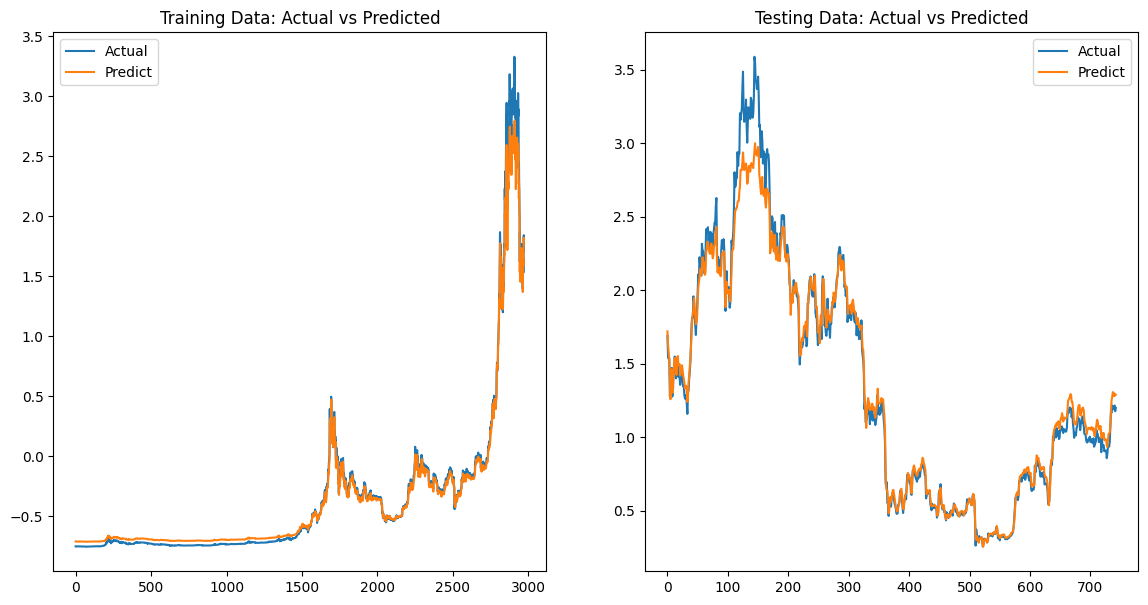

  Metric     Train      Test
0   RMSE  0.066948  0.115164
1    MAE  0.037743  0.068967
2    MSE  0.004482  0.013263
3     R2  0.991212  0.980408


In [21]:
# Initialize and train the LSTM model 5
lstm_5 = LSTM_Models(X_train, y_train, X_test, y_test, model5)
lstm_5.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_5.make_predictions(preprocessor.close_scaler)
lstm_5.plot_predictions(train_comparison_df, test_comparison_df)
results_df5 = lstm_5.evaluate_model(train_comparison_df, test_comparison_df)
print(results_df5)

In [22]:
stop

NameError: name 'stop' is not defined

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# Initialize and train the LSTM model 1
lstm_1 = LSTM_Models(X_train, y_train, X_test, y_test, model1)
lstm_1.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_1.make_predictions(preprocessor.close_scaler)
lstm_1.plot_predictions(train_comparison_df, test_comparison_df)
results_df1 = lstm_1.evaluate_model(train_comparison_df, test_comparison_df)
print(results_df1)

In [ ]:
# Initialize and train the LSTM model 2
lstm_2 = LSTM_Models(X_train, y_train, X_test, y_test, model2)
lstm_2.train_model(epochs=100, batch_size=50)
train_comparison_df, test_comparison_df = lstm_2.make_predictions(preprocessor.close_scaler)
lstm_2.plot_predictions(train_comparison_df, test_comparison_df)
results_df2 = lstm_2.evaluate_model(train_comparison_df, test_comparison_df)
print(results_df2)

In [ ]:
# Initialize and train the LSTM model 2
lstm_3 = LSTM_Models(X_train, y_train, X_test, y_test, model3)
lstm_3.train_model(epochs=100, batch_size=50)
train_comparison_df, test_comparison_df = lstm_3.make_predictions(preprocessor.close_scaler)
lstm_3.plot_predictions(train_comparison_df, test_comparison_df)
results_df3 = lstm_3.evaluate_model(train_comparison_df, test_comparison_df)
print(results_df3)

In [ ]:
# Initialize and train the LSTM model 4
lstm_4 = LSTM_Models(X_train, y_train, X_test, y_test, model4)
lstm_4.train_model(epochs=100, batch_size=50)
train_comparison_df,test_comparison_df = lstm_4.make_predictions(preprocessor.close_scaler)
lstm_4.plot_predictions(train_comparison_df, test_comparison_df)
results_df4 = lstm_4.evaluate_model(train_comparison_df, test_comparison_df)
print(results_df4)


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [42]:
class DataPreprocessing:
    def __init__(self, data, target_columns):
        self.data = data.sort_index(ascending=True)
        if isinstance(target_columns, list):
            missing_cols = [col for col in target_columns if col not in data.columns]
        else:
            missing_cols = [] if target_columns in data.columns else [target_columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} are not in the input dataframe.")
        self.target_columns = target_columns
        self.data_scaled = None  # Initialize the data_scaled attribute

    def normalize_and_scale(self):
        data_normalized = self.data.copy()
        self.scaler = StandardScaler()
        target_data = data_normalized[self.target_columns] if isinstance(self.target_columns, list) else data_normalized[[self.target_columns]]
        if target_data.isnull().values.any():
            raise ValueError("Target column(s) contain null values.")
        data_normalized[self.target_columns] = self.scaler.fit_transform(target_data)
        self.data_scaled = data_normalized
        return self.data_scaled

    def split_data(self, splitter, output_shape='2D'):
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")
        if not 0 <= splitter <= 1:
            raise ValueError("'splitter' should be in range [0, 1].")
        
        split_index = int(len(self.data_scaled) * (1 - splitter))
        data_train = self.data_scaled.iloc[:split_index]
        data_test = self.data_scaled.iloc[split_index:]

        X_train = data_train.drop(columns=self.target_columns)
        y_train = data_train[self.target_columns]

        X_test = data_test.drop(columns=self.target_columns)
        y_test = data_test[self.target_columns]

        if output_shape == '3D':
            X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        elif output_shape != '2D':
            raise ValueError("'output_shape' value must be either '2D' or '3D'.")

        return X_train, y_train.values, X_test, y_test.values
    
    def visualize_split(self, train_data, test_data):
        target_data_restored = self.data[self.target_columns]
        y_train_restored = target_data_restored[:len(train_data)]
        y_test_restored = target_data_restored[len(train_data):]

        train_dates = self.data.index[:len(train_data)]
        test_dates = self.data.index[-len(test_data):]

        p = figure(width=950, height=500, x_axis_type="datetime", title="Training and Testing Data")

        p.xgrid.grid_line_color = "gray"
        p.ygrid.grid_line_color = "gray"
        p.xgrid.grid_line_alpha = 0.3
        p.ygrid.grid_line_alpha = 0.3

        # Training Data Line
        p.line(train_dates, y_train_restored, color='blue', legend_label='Training Data', line_width=2)
        p.line(test_dates, y_test_restored, color='orange', legend_label='Testing Data', line_width=2)

        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Value", "$@y{0,0.00}")],
                  formatters={"@x": "datetime"})

        p.add_tools(hover)
        p.toolbar.logo = None
        # Show the dynamic line chart
        show(p)


In [43]:
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
target_columns ='Close'

# Instantiate the DataPreprocessing class
preprocessor = DataPreprocessing(data, target_columns)
data_normalized = preprocessor.normalize_and_scale()

# Split the data into training and testing sets
X_train, y_train, X_test, y_test = preprocessor.split_data(splitter=0.2, output_shape='3D')

# Print out the dimensions of the train and test sets
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

# Visualize the split between the train and test set
preprocessor.visualize_split(X_train, X_test)

(2972, 1, 5) (2972,) (743, 1, 5) (743,)


In [64]:
# For Univariate LSTM model with 'Close' column
target_columns_uni ='Close'
preprocessor_uni = DataPreprocessing(data, target_columns_uni)
data_normalized_uni = preprocessor_uni.normalize_and_scale()
X_train_close, y_train_close, X_test_close, y_test_close = preprocessor_uni.split_data(splitter=0.2, output_shape='3D')
print(X_train_close.shape, y_train_close.shape, X_test_close.shape, y_test_close.shape)

(2972, 1, 5) (2972,) (743, 1, 5) (743,)


In [65]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
target_columns_multi = ['Open', 'High', 'Low', 'Close']
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.2, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)


(2972, 1, 2) (2972, 4) (743, 1, 2) (743, 4)


# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

In [46]:
class DataPreprocessing:
    def __init__(self, data, target_columns):
        self.data = data.sort_index(ascending=True)
        if isinstance(target_columns, list):
            missing_cols = [col for col in target_columns if col not in data.columns]
        else:
            missing_cols = [] if target_columns in data.columns else [target_columns]
        if missing_cols:
            raise ValueError(f"Columns {missing_cols} are not in the input dataframe.")
        self.target_columns = target_columns
        self.data_scaled = None  # Initialize the data_scaled attribute

    def normalize_and_scale(self):
        data_normalized = self.data.copy()
        self.scaler = StandardScaler()

        if isinstance(self.target_columns, list):
            target_data = data_normalized[self.target_columns]
            scaler_filepath = './assets/scaler_multi.pkl'
        else:
            target_data = data_normalized[[self.target_columns]]
            scaler_filepath = './assets/scaler_uni.pkl'

        if target_data.isnull().values.any():
            raise ValueError("Target column(s) contain null values.")

        # Normalize the target_data
        data_normalized[self.target_columns] = self.scaler.fit_transform(target_data)
        self.data_scaled = data_normalized

        # Save the fitted scaler
        with open(scaler_filepath, 'wb') as file:
            pickle.dump(self.scaler, file)

        return self.data_scaled

    def split_data(self, splitter, output_shape='2D'):
        if self.data_scaled is None:
            raise ValueError("Please call 'normalize_and_scale' method before splitting the data.")
        if not 0 <= splitter <= 1:
            raise ValueError("'splitter' should be in range [0, 1].")
        
        split_index = int(len(self.data_scaled) * (1 - splitter))
        data_train = self.data_scaled.iloc[:split_index]
        data_test = self.data_scaled.iloc[split_index:]

        X_train = data_train.drop(columns=self.target_columns)
        y_train = data_train[self.target_columns]

        X_test = data_test.drop(columns=self.target_columns)
        y_test = data_test[self.target_columns]

        if output_shape == '3D':
            X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
            X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
        elif output_shape != '2D':
            raise ValueError("'output_shape' value must be either '2D' or '3D'.")

        return X_train, y_train.values, X_test, y_test.values
    
    def visualize_split(self, train_data, test_data):
        target_data_restored = self.data[self.target_columns]
        y_train_restored = target_data_restored[:len(train_data)]
        y_test_restored = target_data_restored[len(train_data):]

        train_dates = self.data.index[:len(train_data)]
        test_dates = self.data.index[-len(test_data):]

        p = figure(width=950, height=500, x_axis_type="datetime", title="Training and Testing Data")

        p.xgrid.grid_line_color = "gray"
        p.ygrid.grid_line_color = "gray"
        p.xgrid.grid_line_alpha = 0.3
        p.ygrid.grid_line_alpha = 0.3

        # Training Data Line
        p.line(train_dates, y_train_restored, color='blue', legend_label='Training Data', line_width=2)
        p.line(test_dates, y_test_restored, color='orange', legend_label='Testing Data', line_width=2)

        hover = HoverTool(tooltips=[("Date", "@x{%F}"), ("Value", "$@y{0,0.00}")],
                  formatters={"@x": "datetime"})

        p.add_tools(hover)
        p.toolbar.logo = None
        # Show the dynamic line chart
        show(p)


In [48]:
# For Univariate LSTM model with 'Close' column
target_columns_uni ='Close'
preprocessor_uni = DataPreprocessing(data, target_columns_uni)
data_normalized_uni = preprocessor_uni.normalize_and_scale()
X_train_close, y_train_close, X_test_close, y_test_close = preprocessor_uni.split_data(splitter=0.2, output_shape='3D')
print(X_train_close.shape, y_train_close.shape, X_test_close.shape, y_test_close.shape)

(2972, 1, 5) (2972,) (743, 1, 5) (743,)


In [49]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
target_columns_multi = ['Open', 'High', 'Low', 'Close']
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.2, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)


(2972, 1, 2) (2972, 4) (743, 1, 2) (743, 4)


In [55]:
class LSTM_Models:
    def __init__(self, X_train, y_train, X_test, y_test, model, scaler_type):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = model
        self.scaler_type = scaler_type

        # Load the correct scaler based on the type
        if self.scaler_type == "uni":
            scaler_filepath = './assets/scaler_uni.pkl'
        else:  # Assume multi if not uni
            scaler_filepath = './assets/scaler_multi.pkl'
        
        with open(scaler_filepath, 'rb') as file:
            self.scaler = pickle.load(file)
            
    def train_model(self, epochs=100, batch_size=50):
        tf.compat.v1.reset_default_graph()
        self.history = self.model.fit(self.X_train, self.y_train, epochs=epochs, batch_size=batch_size, verbose=2,validation_data=(self.X_test, self.y_test), shuffle=False)

    def make_predictions(self):
        # Make predictions on the normalized data
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)

        # Check the number of LSTM layers in the model
        num_lstm_layers = sum([isinstance(layer, LSTM) for layer in self.model.layers])

        if num_lstm_layers == 1:
            # For models with a single LSTM layer, no reshaping is needed
            train_predict = self.scaler.inverse_transform(train_predict)
            test_predict = self.scaler.inverse_transform(test_predict)
        else:
            # For models with multiple LSTM layers, reshape the predictions
            train_predict = train_predict.reshape(-1, 1)
            test_predict = test_predict.reshape(-1, 1)
            train_predict = self.scaler.inverse_transform(train_predict)
            test_predict = self.scaler.inverse_transform(test_predict)

        y_train_rescaled = self.scaler.inverse_transform([self.y_train])
        y_test_rescaled = self.scaler.inverse_transform([self.y_test])

        # Create DataFrames to compare actual vs predicted values for the training and testing data
        train_comparison_df = pd.DataFrame({
            'Actual': y_train_rescaled[0],
            'Predict': train_predict[:, 0]
        })
        test_comparison_df = pd.DataFrame({
            'Actual': y_test_rescaled[0],
            'Predict': test_predict[:, 0]
        })

        return train_comparison_df, test_comparison_df


    def evaluate_model(self, train_comparison_df, test_comparison_df):
        # Calculate metrics for the training data
        train_rmse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'], squared=False)
        train_mae = mean_absolute_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_mse = mean_squared_error(train_comparison_df['Actual'], train_comparison_df['Predict'])
        train_r2 = r2_score(train_comparison_df['Actual'], train_comparison_df['Predict'])
        # Calculate metrics for the testing data
        test_rmse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'], squared=False)
        test_mae = mean_absolute_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_mse = mean_squared_error(test_comparison_df['Actual'], test_comparison_df['Predict'])
        test_r2 = r2_score(test_comparison_df['Actual'], test_comparison_df['Predict'])
        # Create a DataFrame to hold the results
        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df

    def plot_predictions(self, train_comparison_df, test_comparison_df):
        plt.figure(figsize=(14, 7))
        # Plot the actual and predicted values for the training data
        plt.subplot(1, 2, 1)
        plt.plot(train_comparison_df['Actual'], label='Actual')
        plt.plot(train_comparison_df['Predict'], label='Predict')
        plt.title('Training Data: Actual vs Predicted')
        plt.legend()
        # Plot the actual and predicted values for the testing data
        plt.subplot(1, 2, 2)
        plt.plot(test_comparison_df['Actual'], label='Actual')
        plt.plot(test_comparison_df['Predict'], label='Predict')
        plt.title('Testing Data: Actual vs Predicted')
        plt.legend()
        # Show the plot
        plt.show()

In [68]:
# For Univariate LSTM model with 'Close' column
target_columns_uni ='Close'
preprocessor_uni = DataPreprocessing(data, target_columns_uni)
data_normalized_uni = preprocessor_uni.normalize_and_scale()
X_train_close, y_train_close, X_test_close, y_test_close = preprocessor_uni.split_data(splitter=0.2, output_shape='3D')
print(X_train_close.shape, y_train_close.shape, X_test_close.shape, y_test_close.shape)

(2972, 1, 5) (2972,) (743, 1, 5) (743,)


In [69]:
# For Univariate LSTM model with 'Close' column
univariate_close_model = Sequential()
univariate_close_model.add(LSTM(256,activation="tanh",input_shape=(1,5)))
univariate_close_model.add(Dropout(0.15))
univariate_close_model.add(Dense(1))
univariate_close_model.compile(loss='mean_squared_error', optimizer='adam')
univariate_close_model.summary()

lstm_univariate_close = LSTM_Models(X_train_close, y_train_close, X_test_close, y_test_close, univariate_close_model, 'uni')
lstm_univariate_close.train_model(epochs=100, batch_size=50)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               268288    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
60/60 - 3s - loss: 0.4907 - val_loss: 2.4088 - 3s/epoch - 43ms/step
Epoch 2/100
60/60 - 1s - loss: 0.8315 - val_loss: 3.0110 - 504ms/epoch - 8ms/step
Epoch 3/100
60/60 - 1s - loss: 0.7408 - val_loss: 3.1947 - 508ms/epoch - 8ms/step
Epoch 4/100
60/60 - 1s - loss: 0.6756 - val_loss: 3.3337 - 513ms/epoch

24/24 [==============================] - 0s 3ms/step


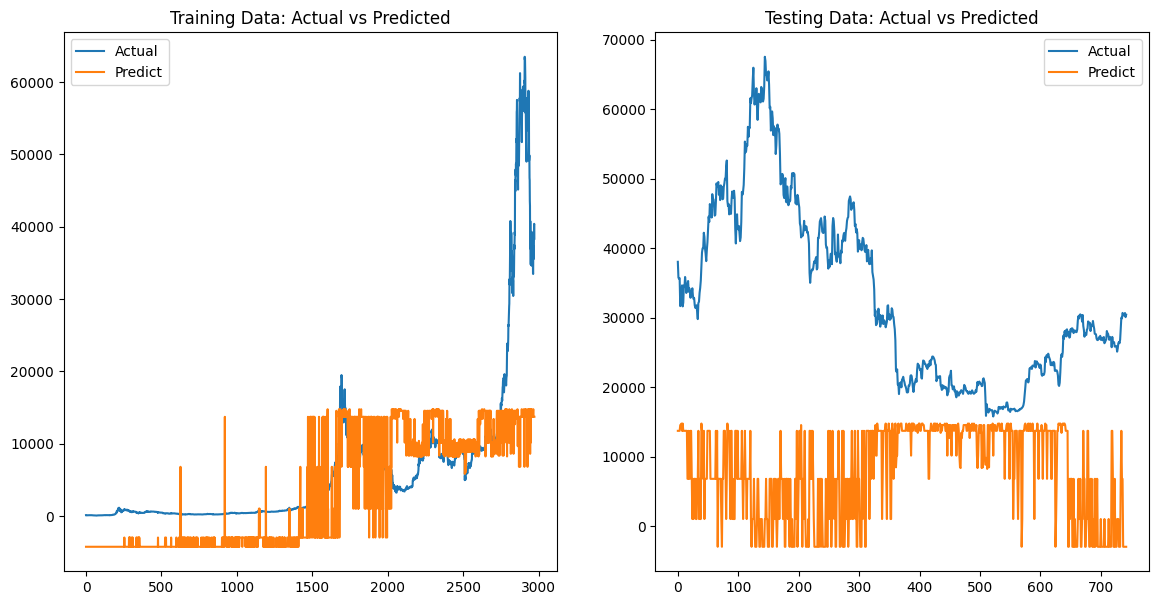

  Metric         Train          Test
0   RMSE  9.506094e+03  3.001917e+04
1    MAE  5.918697e+03  2.476774e+04
2    MSE  9.036583e+07  9.011504e+08
3     R2  2.667771e-01 -4.509002e+00


In [70]:
train_comparison_df_uni,test_comparison_df_uni = lstm_univariate_close.make_predictions()
lstm_univariate_close.plot_predictions(train_comparison_df_uni, test_comparison_df_uni)
results_df_uni = lstm_univariate_close.evaluate_model(train_comparison_df_uni, test_comparison_df_uni)
print(results_df_uni)

In [71]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
target_columns_multi = ['Open', 'High', 'Low', 'Close']
preprocessor_multi = DataPreprocessing(data, target_columns_multi)
data_normalized_multi = preprocessor_multi.normalize_and_scale()
X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv = preprocessor_multi.split_data(splitter=0.2, output_shape='3D')
print(X_train_ohlcv.shape, y_train_ohlcv.shape, X_test_ohlcv.shape, y_test_ohlcv.shape)


(2972, 1, 2) (2972, 4) (743, 1, 2) (743, 4)


In [72]:
# For Multivariate LSTM model with ('Open', 'High', 'Low', 'Close') columns
multivariate_ohlcv_model = Sequential()
multivariate_ohlcv_model.add(LSTM(256,activation="tanh",input_shape=(1,5)))
multivariate_ohlcv_model.add(Dropout(0.15))
multivariate_ohlcv_model.add(Dense(1))
multivariate_ohlcv_model.compile(loss='mean_squared_error', optimizer='adam')
multivariate_ohlcv_model.summary()

lstm_multivariate_ohlcv = LSTM_Models(X_train_ohlcv, y_train_ohlcv, X_test_ohlcv, y_test_ohlcv, multivariate_ohlcv_model, 'multi')
lstm_multivariate_ohlcv.train_model(epochs=100, batch_size=50)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               268288    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 268,545
Trainable params: 268,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


ValueError: in user code:

    File "C:\Users\migue\anaconda3\envs\thesis\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\migue\anaconda3\envs\thesis\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\migue\anaconda3\envs\thesis\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\migue\anaconda3\envs\thesis\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\migue\anaconda3\envs\thesis\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\migue\anaconda3\envs\thesis\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 1, 5), found shape=(None, 1, 2)


In [ ]:
train_comparison_df_multi,test_comparison_df_multi = lstm_multivariate_ohlcv.make_predictions()
lstm_multivariate_ohlcv.plot_predictions(train_comparison_df_multi, test_comparison_df_multi)
results_df_multi = lstm_multivariate_ohlcv.evaluate_model(train_comparison_df_multi, test_comparison_df_multi)
print(results_df_multi)


In [67]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3715 entries, 2023-06-29 to 2013-04-28
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        3715 non-null   float64
 1   High        3715 non-null   float64
 2   Low         3715 non-null   float64
 3   Close       3715 non-null   float64
 4   Volume      3715 non-null   float64
 5   Market Cap  3715 non-null   float64
dtypes: float64(6)
memory usage: 203.2 KB


# Block 6 - Linear Regression Models

In [ ]:
class LinearRegression_Model:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = LinearRegression()

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        self.train_predict = self.model.predict(self.X_train)
        self.test_predict = self.model.predict(self.X_test)
        return self.train_predict, self.test_predict

    def plot_predictions(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.y_test, label='Actual')
        plt.plot(self.test_predict, label='Predicted')
        plt.title('Test Data: Actual vs Predicted')
        plt.legend()
        plt.show()

    def evaluate_model(self):
        train_rmse = mean_squared_error(self.y_train, self.train_predict, squared=False)
        train_mae = mean_absolute_error(self.y_train, self.train_predict)
        train_mse = mean_squared_error(self.y_train, self.train_predict)
        train_r2 = r2_score(self.y_train, self.train_predict)

        test_rmse = mean_squared_error(self.y_test, self.test_predict, squared=False)
        test_mae = mean_absolute_error(self.y_test, self.test_predict)
        test_mse = mean_squared_error(self.y_test, self.test_predict)
        test_r2 = r2_score(self.y_test, self.test_predict)

        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df


In [ ]:
# Initialize and train the model
linear_model = LinearRegression_Model(X_train, y_train, X_test, y_test)
linear_model.train_model()

# Make predictions
train_predict, test_predict = linear_model.make_predictions()

# Plot the predictions
linear_model.plot_predictions()

# Evaluate the model
results = linear_model.evaluate_model()
print(results)


In [ ]:
class LogisticRegression_Models:
    def __init__(self, X_train, y_train, X_test, y_test):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.model = LogisticRegression()

    def train_model(self):
        self.model.fit(self.X_train, self.y_train)

    def make_predictions(self):
        train_predict = self.model.predict(self.X_train)
        test_predict = self.model.predict(self.X_test)
        return train_predict, test_predict
    
    def plot_predictions(self):
        plt.figure(figsize=(14, 7))
        plt.plot(self.y_test, label='Actual')
        plt.plot(self.y_test_pred, label='Predicted')
        plt.title('Test Data: Actual vs Predicted')
        plt.legend()
        plt.show()

    def evaluate_model(self, train_predict, test_predict):
        train_rmse = mean_squared_error(self.y_train, train_predict, squared=False)
        train_mae = mean_absolute_error(self.y_train, train_predict)
        train_mse = mean_squared_error(self.y_train, train_predict)
        train_r2 = r2_score(self.y_train, train_predict)

        test_rmse = mean_squared_error(self.y_test, test_predict, squared=False)
        test_mae = mean_absolute_error(self.y_test, test_predict)
        test_mse = mean_squared_error(self.y_test, test_predict)
        test_r2 = r2_score(self.y_test, test_predict)

        results_df = pd.DataFrame({
            'Metric': ['RMSE', 'MAE', 'MSE', 'R2'],
            'Train': [train_rmse, train_mae, train_mse, train_r2],
            'Test': [test_rmse, test_mae, test_mse, test_r2]
        })

        return results_df